In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EDA").getOrCreate()

tripdata_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group_8/tripdata_cleaned", header=True, inferSchema=True)


In [2]:
tripdata_df.printSchema()
tripdata_df.show()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = 

23/11/28 02:57:30 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+
|hvfhs_license_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|
+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+-----

In [3]:
from pyspark.sql.functions import when, col

# Mapping of codes to company names
code_to_company = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

# Initialize the column expression with a default value (here we use the existing column value)
column_expr = col("hvfhs_license_num")

# Chain when clauses for each mapping
for code, company in code_to_company.items():
    column_expr = when(col("hvfhs_license_num") == code, company).otherwise(column_expr)

# Apply the transformation to create the new "company" column
tripdata_df = tripdata_df.withColumn("company", column_expr)

# Show some rows to verify the change
tripdata_df.show()


+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+-------+
|hvfhs_license_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|company|
+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+

In [4]:

num_rows = tripdata_df.count()
num_cols = len(tripdata_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 744665024
Number of columns: 29


In [5]:
tripdata_df = tripdata_df.drop("request_datetime", "pickup_datetime")
tripdata_df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = tru

In [57]:
# from pyspark.sql import functions as F

# # Group by 'hvfhs_license_num' and count the rows in each group
# company_df = tripdata_df.groupBy("hvfhs_license_num").agg(F.count("*").alias("count"))

# # Convert the resulting PySpark DataFrame to a Pandas DataFrame
# pandas_df = company_df.toPandas()


In [58]:
from pyspark.sql import functions as F

# Group by pickup hour and count the trips
trip_distribution_hour = tripdata_df.groupBy("pickup_hour").agg(F.count("*").alias("trip_count"))
trip_distribution_hour.show()

+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|         12|  32524031|
|         22|  39750966|
|          1|  19715255|
|         13|  33926229|
|          6|  19171781|
|         16|  38930021|
|          3|  10672267|
|         20|  41741372|
|          5|  12099365|
|         19|  44796704|
|         15|  37891053|
|          9|  33564863|
|         17|  43041129|
|          4|  10071665|
|          8|  35394175|
|         23|  35876804|
|          7|  28685329|
|         10|  31186431|
|         21|  40304711|
|         11|  31369120|
+-----------+----------+
only showing top 20 rows



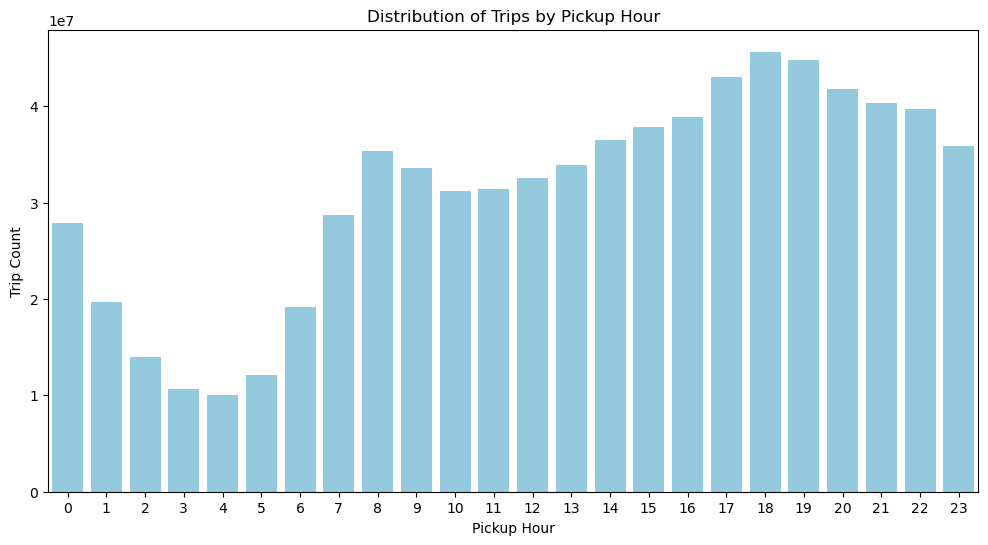

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
trip_distribution_hour_pd = trip_distribution_hour.toPandas()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x="pickup_hour", y="trip_count", data=trip_distribution_hour_pd, color="skyblue")
plt.title("Distribution of Trips by Pickup Hour")
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Count")
plt.show()

In [60]:
average_distance_hour = tripdata_df.groupBy("pickup_hour").agg(F.avg("trip_miles").alias("avg_trip_distance"))
average_distance_hour.show()


+-----------+------------------+
|pickup_hour| avg_trip_distance|
+-----------+------------------+
|         12|  4.71941254320536|
|         22|  5.02310612750896|
|          1| 4.984238354512783|
|         13| 4.741378967052308|
|          6| 6.213042341866936|
|         16|  4.52695142954072|
|          3| 5.529373796495155|
|         20| 4.693576934557882|
|          5| 6.991394083408505|
|         19| 4.373299019209094|
|         15|4.6436472216805385|
|          9| 4.593569584776799|
|         17|   4.3374866567975|
|          4| 6.501131029179386|
|          8|  4.56516398254798|
|         23| 5.057714645457271|
|          7| 5.080538101550106|
|         10| 4.703458713951596|
|         21|4.9253949466602105|
|         11| 4.723665379296589|
+-----------+------------------+
only showing top 20 rows



In [61]:
total_fare_by_month = tripdata_df.groupBy("pickup_month").agg(F.sum("base_passenger_fare").alias("total_fare"))
total_fare_by_month.show()

+------------+--------------------+
|pickup_month|          total_fare|
+------------+--------------------+
|          12| 9.739178004763293E8|
|           1|  8.44657697866253E8|
|           6|1.3389558797879727E9|
|           3| 1.281636120728157E9|
|           5|1.3009899662781098E9|
|           9|1.3947373948369093E9|
|           4| 1.151867144428245E9|
|           8|1.2684723856181812E9|
|           7|1.3037595666385615E9|
|          10|1.4681650790564635E9|
|          11|1.3760594442359014E9|
|           2|  1.22920181419726E9|
+------------+--------------------+



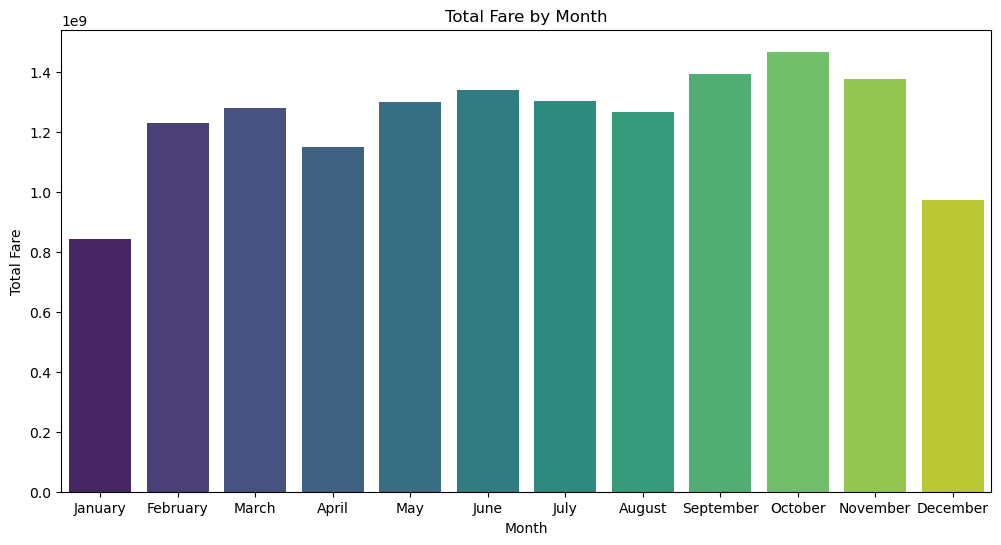

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Assuming 'total_fare_by_month' is a DataFrame with columns 'pickup_month' and 'total_fare'
# If your DataFrame is not created yet, make sure to run the provided code first.

# Convert the DataFrame to Pandas for easy plotting
total_fare_by_month_pd = total_fare_by_month.toPandas()

# Define the order of months
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Map numerical month values to their corresponding month names
total_fare_by_month_pd['pickup_month'] = total_fare_by_month_pd['pickup_month'].apply(lambda x: month_order[x - 1])

# Sort DataFrame by month order
total_fare_by_month_pd = total_fare_by_month_pd.sort_values('pickup_month', key=lambda x: x.map({month: i for i, month in enumerate(month_order)}))

# Plot the total fare by month
plt.figure(figsize=(12, 6))
sns.barplot(x="pickup_month", y="total_fare", data=total_fare_by_month_pd, palette="viridis")
plt.title("Total Fare by Month")
plt.xlabel("Month")
plt.ylabel("Total Fare")
plt.show()

In [63]:
tripdata_df = tripdata_df.drop("features_fare")

In [64]:
tripdata_df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = tru

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


numeric_columns = ["trip_miles", "base_passenger_fare", "tolls","bcf","sales_tax","congestion_surcharge","driver_pay","request_hour","request_day_of_week","request_month","pickup_hour","pickup_day_of_week","pickup_month"] 


selected_df = tripdata_df.select(numeric_columns)


assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_df = assembler.transform(selected_df)


correlation_matrix = Correlation.corr(assembled_df, "features")


correlation_array = correlation_matrix.collect()[0]["pearson({})".format("features")].values


print("Correlation Matrix:")
print(correlation_array)

Correlation Matrix:
[ 1.00000000e+00  8.53762138e-01  4.99415483e-01  7.48223575e-01
  6.48683797e-01  4.14615862e-02  8.59156340e-01 -3.48196871e-02
 -1.60602738e-02  1.07447495e-02 -3.59772177e-02 -1.59190839e-02
  1.07488552e-02  8.53762138e-01  1.00000000e+00  4.85921361e-01
  8.58845634e-01  7.71041138e-01  1.57703424e-01  9.20575600e-01
 -4.19851378e-03  9.24239534e-04  4.39048577e-02 -5.18566009e-03
  5.93414924e-04  4.39102551e-02  4.99415483e-01  4.85921361e-01
  1.00000000e+00  5.41173141e-01  1.33860296e-01 -8.54311514e-03
  5.07557792e-01 -1.24797104e-02 -8.87005333e-03  1.18391057e-02
 -1.27378417e-02 -8.82446530e-03  1.18400946e-02  7.48223575e-01
  8.58845634e-01  5.41173141e-01  1.00000000e+00  6.67268040e-01
  1.43838293e-01  7.98729671e-01 -7.62990832e-03 -2.97019318e-03
  4.58683220e-02 -8.51988788e-03 -3.29673614e-03  4.58725412e-02
  6.48683797e-01  7.71041138e-01  1.33860296e-01  6.67268040e-01
  1.00000000e+00  2.52710762e-01  7.17243019e-01 -7.57291809e-03
  1.9

In [14]:
tripdata_df.select("request_hour").distinct().show()

+------------+
|request_hour|
+------------+
|          12|
|          22|
|           1|
|          13|
|           6|
|          16|
|           3|
|          20|
|           5|
|          19|
|          15|
|           9|
|          17|
|           4|
|           8|
|          23|
|           7|
|          10|
|          21|
|          11|
+------------+
only showing top 20 rows



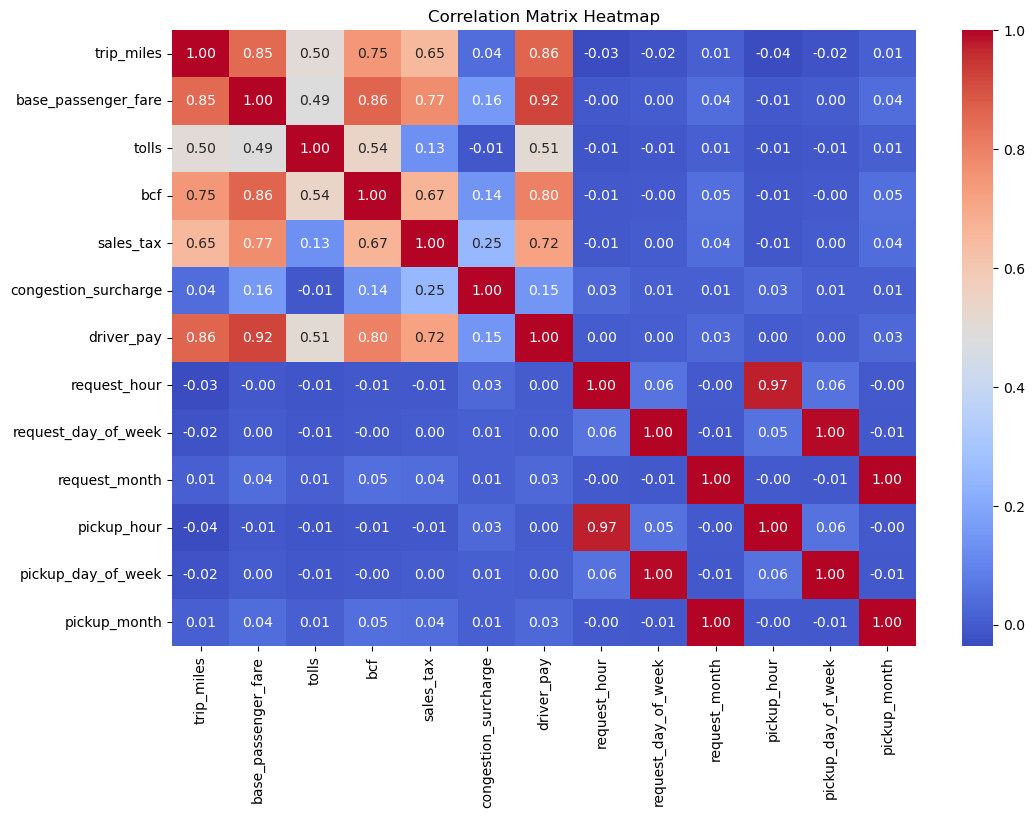

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
size = int(np.sqrt(len(correlation_array)))
correlation_matrix = np.reshape(correlation_array, (size, size))
numeric_columns = ["trip_miles", "base_passenger_fare", "tolls","bcf","sales_tax","congestion_surcharge","driver_pay"]
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",xticklabels=numeric_columns,yticklabels=numeric_columns)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [11]:
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

categorical_cols = ['PULocationID', 'DOLocationID', 'request_time_of_day', 'pickup_time_of_day', 'company']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(tripdata_df) for col in categorical_cols]

pipeline_indexing = Pipeline(stages=indexers)
df_transformed = pipeline_indexing.fit(tripdata_df).transform(tripdata_df)

feature_columns = ['trip_miles', 'trip_time', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
                 'driver_pay', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
                   'request_hour', 'request_day_of_week', 'request_month', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
                   'PULocationID_index', 'DOLocationID_index', 'request_time_of_day_index', 'pickup_time_of_day_index', 'company_index']

# Create a VectorAssembler to assemble the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_transformed)

# Use StandardScaler to scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Display the transformed and scaled DataFrame
df_scaled.select('scaled_features').show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
fraction = 0.4  
sample = df_scaled.sample(withReplacement=False, fraction=fraction, seed=42)

In [37]:
fraction = 0.5 
sample1 = df_scaled.sample(withReplacement=False, fraction=fraction, seed=42)

In [13]:
sample.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = tru

In [ ]:
columns_to_drop = ['features','scaled_features']

# Drop multiple columns
sample = sample.drop(*columns_to_drop)

In [7]:
num_rows = sample.count()
num_cols = len(sample.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")
744665024
148931722

Number of rows: 148931722
Number of columns: 33


In [18]:
df_scaled.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_match_flag: integer (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = true)
 |-- pickup_time_of_day: string (nulla

In [15]:
df_scaled.show()

+-----------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+-------+------------------+------------------+-------------------------+------------------------+-------------+--------------------+--------------------+
|hvfhs_license_num|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|company|PULocationID_index|DOLocationID_index|request_time_of_day_index|pickup_time_of_day

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Define the features you want to include
feature_columns = [
    'trip_miles', 'trip_time', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
    'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
    'access_a_ride_flag', 'wav_match_flag',
    'pickup_hour', 'pickup_day_of_week', 'pickup_month'
]

# Create a VectorAssembler to assemble the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features1')
assembled_data = assembler.transform(df_scaled)

# Select only the necessary columns for training
selected_data = assembled_data.select('features1', 'base_passenger_fare')

# Split the data into training and testing sets
train_data, test_data = selected_data.randomSplit([0.8, 0.2], seed=42)

# Define a Linear Regression model
lr = LinearRegression(featuresCol='features1', labelCol='base_passenger_fare')

# Train the model
model = lr.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using a regression evaluator
evaluator = RegressionEvaluator(labelCol='base_passenger_fare', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')



23/11/25 21:26:32 WARN org.apache.spark.ml.util.Instrumentation: [2a77d732] regParam is zero, which might cause numerical instability and overfitting.
23/11/25 21:32:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/25 21:32:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/11/25 21:32:13 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/25 21:32:13 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/11/25 21:32:13 WARN org.apache.spark.ml.util.Instrumentation: [2a77d732] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE) on test data: 5.352904871670274


In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Define the features you want to include
feature_columns = [
    'trip_miles', 'trip_time', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
    'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
    'access_a_ride_flag', 'wav_match_flag',
    'pickup_hour', 'pickup_day_of_week', 'pickup_month'
]

# Create a VectorAssembler to assemble the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(tripdata_df)

# Select only the necessary columns for training
selected_data = assembled_data.select('features', 'base_passenger_fare')

# Split the data into training and testing sets
train_data, test_data = selected_data.randomSplit([0.8, 0.2], seed=42)

# Define a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='base_passenger_fare')

# Train the model
model = lr.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using a regression evaluator
evaluator = RegressionEvaluator(labelCol='base_passenger_fare', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')


23/11/18 21:15:33 WARN org.apache.spark.ml.util.Instrumentation: [e6839bbf] regParam is zero, which might cause numerical instability and overfitting.
23/11/18 21:26:20 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/18 21:26:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/11/18 21:26:21 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/18 21:26:21 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/11/18 21:26:21 WARN org.apache.spark.ml.util.Instrumentation: [e6839bbf] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE) on test data: 5.352904871670282


In [19]:
column_name = "company_index"

# Get unique values in the specified column
unique_values = sample.select(column_name).distinct()

# Show the unique values
unique_values.show()

+-------------+
|company_index|
+-------------+
|          0.0|
|          1.0|
|          3.0|
|          2.0|
+-------------+



In [16]:
columns_to_drop = ['PULocationID', 'DOLocationID', 'request_time_of_day', 'pickup_time_of_day', 'company','hvfhs_license_num','dropoff_datetime']

# Drop multiple columns
sample = sample.drop(*columns_to_drop)

In [ ]:
df_transformed.show()

In [ ]:
columns_to_drop = ['hvfhs_license_num','dropoff_datetime']

# Drop multiple columns
df_transformed = df_transformed.drop(*columns_to_drop)

In [ ]:
fraction = 0.1  # 10% of the data
sample = df_transformed.sample(withReplacement=False, fraction=fraction, seed=42)

# Show the schema of the sampled DataFrame
sample.printSchema()


In [ ]:
from pyspark.ml.feature import StandardScaler

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(selected_data)
scaled_data = scaler_model.transform(selected_data)

In [29]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Define the features you want to include
feature_columns = [
    'trip_miles', 'trip_time', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
    'access_a_ride_flag', 'wav_match_flag',
    'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'PULocationID_index', 'DOLocationID_index','request_time_of_day_index',
    'pickup_time_of_day_index','company_index'
]

# Create a VectorAssembler to assemble the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(sample)

# Select only the necessary columns for training
selected_data = assembled_data.select('features', 'base_passenger_fare')

# Split the data into training and testing sets
train_data, test_data = selected_data.randomSplit([0.8, 0.2], seed=42)

# Define a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='base_passenger_fare')

# Train the model
model = lr.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using a regression evaluator
evaluator = RegressionEvaluator(labelCol='base_passenger_fare', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')

23/11/20 03:28:48 WARN org.apache.spark.ml.util.Instrumentation: [70a99f36] regParam is zero, which might cause numerical instability and overfitting.
23/11/20 03:34:05 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/20 03:34:05 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/11/20 03:34:06 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/20 03:34:06 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/11/20 03:34:06 WARN org.apache.spark.ml.util.Instrumentation: [70a99f36] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE) on test data: 5.3559699525868485


In [32]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr = LinearRegression(featuresCol='scaled_features', labelCol='base_passenger_fare')

# Create a pipeline
pipeline = Pipeline(stages=[scaler, lr])

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0]).build()

# Set up the cross-validator
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=RegressionEvaluator(labelCol='base_passenger_fare', metricName='rmse'),
                                 numFolds=3,  # Adjust as needed
                                 seed=42)

# Train the model
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Evaluate the model using a regression evaluator
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')

# Best hyperparameters from the cross-validation
best_lr_model = cv_model.bestModel.stages[-1]
best_reg_param = best_lr_model._java_obj.getRegParam()
print(f'Best regParam: {best_reg_param}')

Root Mean Squared Error (RMSE) on test data: 5.3560854559259905
Best regParam: 0.01


In [33]:
evaluator = RegressionEvaluator(labelCol='base_passenger_fare', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)
print(f'R-squared (r2) on test data: {r2}')

R-squared (r2) on test data: 0.9098486924295616


In [36]:
predictions.select('features', 'prediction','base_passenger_fare').show()

+--------------------+------------------+-------------------+
|            features|        prediction|base_passenger_fare|
+--------------------+------------------+-------------------+
|(19,[0,1,2,3,4,5,...| 42.70562794102652|              38.04|
|(19,[0,1,2,3,4,5,...| 47.72322987041013|              49.84|
|(19,[0,1,2,3,4,5,...|44.112365522651075|              39.37|
|(19,[0,1,2,3,4,5,...| 51.31108095489306|              49.75|
|(19,[0,1,2,3,4,5,...| 49.28420921654715|              47.46|
|(19,[0,1,2,3,4,5,...| 53.93266048512578|               50.5|
|(19,[0,1,2,3,4,5,...|56.779014109841114|              50.25|
|(19,[0,1,2,3,4,5,...| 59.72601747643346|              55.88|
|(19,[0,1,2,3,4,5,...| 63.01857696742875|              56.04|
|(19,[0,1,2,3,4,5,...| 58.90036483800964|              58.08|
|(19,[0,1,2,3,4,5,...|59.507556227417595|              51.97|
|(19,[0,1,2,3,4,5,...| 67.36315914224615|              59.53|
|(19,[0,1,2,3,4,5,...| 56.99950389973919|              47.99|
|(19,[0,

In [40]:
coefficients = model.coefficients

# Display the coefficients
print("Feature Coefficients:")
for feature, coef in zip(feature_columns, coefficients):
    print(f"{feature}: {coef}")

Feature Coefficients:
trip_miles: 0.48013570776003983
trip_time: -0.0005215201125820363
tolls: 0.08181103226982195
bcf: 7.830962949646328
sales_tax: 2.134176163794885
congestion_surcharge: -0.09874723128849777
driver_pay: 0.5783498515751737
shared_request_flag: 0.0
shared_match_flag: 0.0
access_a_ride_flag: 0.0
wav_match_flag: 0.0
pickup_hour: 0.009113001429199909
pickup_day_of_week: 0.016761048864438213
pickup_month: 0.046280807387064776
PULocationID_index: -0.005618014285791121
DOLocationID_index: -0.005442934376504754
request_time_of_day_index: -0.0571204666687147
pickup_time_of_day_index: 0.10066832471400645
company_index: 1.346710679942088


In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

feature_columns = [
    'trip_miles', 'trip_time', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
    'access_a_ride_flag', 'wav_match_flag',
    'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'PULocationID_index', 'DOLocationID_index','request_time_of_day_index',
    'pickup_time_of_day_index','company_index'
]


feature_columns = [
    'trip_miles', 'shared_request_flag', 'shared_match_flag',
    'access_a_ride_flag', 'wav_match_flag',
    'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'PULocationID_index', 'DOLocationID_index','request_time_of_day_index',
    'pickup_time_of_day_index','company_index'
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(sample)

selected_data = assembled_data.select('features','base_passenger_fare' )

train_data, test_data = selected_data.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeRegressor(featuresCol='features', labelCol='base_passenger_fare',maxBins=300)

# Train the model
model = dt.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using a regression evaluator
evaluator = RegressionEvaluator(labelCol='base_passenger_fare', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')

# Display the first few predictions
predictions.select('features', 'base_passenger_fare', 'prediction').show(5)


Root Mean Squared Error (RMSE) on test data: 5.155512213004813


+--------------------+-------------------+------------------+
|            features|base_passenger_fare|        prediction|
+--------------------+-------------------+------------------+
|(19,[0,1,2,3,4,5,...|              38.04|46.058250903467055|
|(19,[0,1,2,3,4,5,...|              43.37|46.058250903467055|
|(19,[0,1,2,3,4,5,...|              37.55| 37.88448518882649|
|(19,[0,1,2,3,4,5,...|              45.53|46.058250903467055|
|(19,[0,1,2,3,4,5,...|              47.07|46.058250903467055|
+--------------------+-------------------+------------------+
only showing top 5 rows



In [ ]:
sample.printSchema()
sample.show()

In [14]:
columns_to_drop = ['features','scaled_features']

# Drop multiple columns
sample = sample.drop(*columns_to_drop)

In [ ]:
assembler = VectorAssembler(inputCols='feature_columns', outputCol='features')

In [ ]:
sample1.printSchema()

In [40]:
columns_to_drop = ['scaled_features']

# Drop multiple columns
sample1 = sample1.drop(*columns_to_drop)

In [42]:
columns_to_drop = ['features']

# Drop multiple columns
sample1 = sample1.drop(*columns_to_drop)

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming 'df' is your DataFrame with 'features' and 'scaled_features' columns

# Define the target variable
target_column = "base_passenger_fare"

# Split the data into training and testing sets
train_data, test_data = sample.randomSplit([0.8, 0.2], seed=42)

# Define the GBTRegressor model
gbt = GBTRegressor(featuresCol="scaled_features", labelCol=target_column, maxIter=10, maxDepth=5)

# Create a pipeline
pipeline = Pipeline(stages=[gbt])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


Root Mean Squared Error (RMSE) on test data: 4.811967800076082


In [18]:

predictions.select("scaled_features", "base_passenger_fare","prediction").show()

+--------------------+-------------------+------------------+
|     scaled_features|base_passenger_fare|        prediction|
+--------------------+-------------------+------------------+
|[-0.8092515690324...|               8.09| 6.286793593671059|
|[-0.5661376426463...|              15.37| 12.07145387033986|
|[0.39371215560389...|               25.0| 25.64647622419353|
|[3.63343033018599...|              53.77| 52.40582987425725|
|[-0.2257781457058...|              25.12| 23.43559062481498|
|[-0.5499300475539...|              11.46| 9.692106508641567|
|[2.09550964030655...|              57.17| 51.13768262292767|
|[-0.4977055744784...|              11.48| 9.692106508641567|
|[-0.5787435499404...|              28.54| 23.43559062481498|
|[-0.4796971354868...|              11.74| 9.692106508641567|
|[0.10737797563804...|              20.13| 12.07145387033986|
|[0.17761088770514...|              20.17|17.268836250914454|
|[-0.6399722425117...|               8.73| 6.286793593671059|
|[-0.398

In [20]:
predictions.select("features", "prediction").show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[0.32,451.0,0.0,0...| 6.286793593671059|
|[1.67,974.0,0.0,0...| 12.07145387033986|
|[7.0,1486.0,6.27,...| 25.64647622419353|
|[24.99,2991.0,6.2...| 52.40582987425725|
|[3.56,1657.0,0.0,...| 23.43559062481498|
|[1.76,855.0,0.0,0...| 9.692106508641567|
|[16.45,1906.0,6.2...| 51.13768262292767|
|[2.05,797.0,0.0,0...| 9.692106508641567|
|[1.6,682.0,0.0,0....| 23.43559062481498|
|[2.15,825.0,0.0,0...| 9.692106508641567|
|[5.41,1394.0,0.0,...| 12.07145387033986|
|[5.8,1182.0,0.0,0...|17.268836250914454|
|[1.26,503.0,0.0,0...| 6.286793593671059|
|[2.6,844.0,0.0,0....| 9.692106508641567|
|[1.51,567.0,0.0,0...| 6.286793593671059|
|[4.3,1110.0,0.0,0...| 19.53214767448033|
|[1.38,354.0,0.0,0...| 6.286793593671059|
|[3.02,601.0,0.0,0...| 9.692106508641567|
|[3.89,1546.0,0.0,...|13.642718776464104|
|[0.83,420.0,0.0,0...| 12.07145387033986|
+--------------------+------------

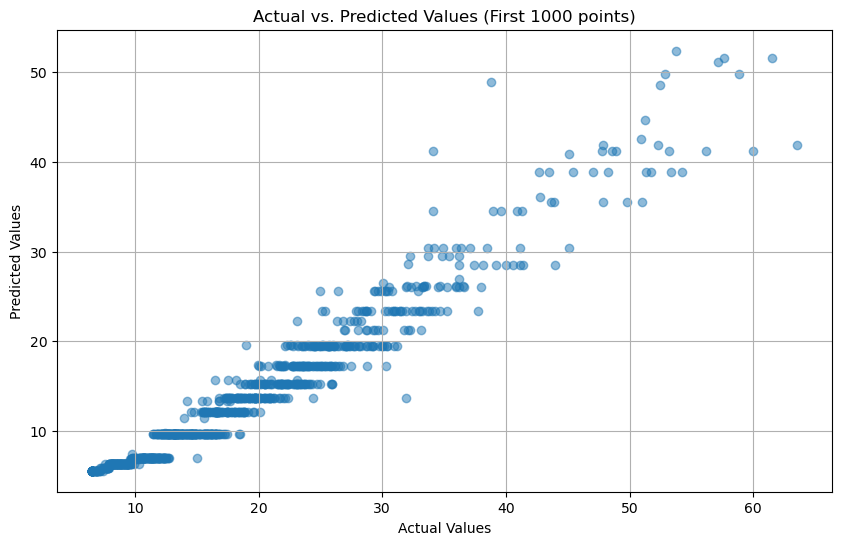

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas for easier plotting
predictions_pd = predictions.select("base_passenger_fare", "prediction").limit(1000).toPandas()

# Scatter plot of actual vs. predicted values for the first 1000 points
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["base_passenger_fare"], predictions_pd["prediction"], alpha=0.5)
plt.title("Actual vs. Predicted Values (First 1000 points)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


In [25]:
feature_importances = model.stages[-1].featureImportances.toArray()
for i in range(len(feature_columns)):
    print(f"{feature_columns[i]}: {feature_importances[i]}")

trip_miles: 0.024403031681310715
trip_time: 0.009317399987871065
tolls: 0.02174371353545215
bcf: 0.052783016713650224
sales_tax: 0.24262673535358822
congestion_surcharge: 0.0022005922354708593
driver_pay: 0.6377216419324825
shared_request_flag: 0.0
shared_match_flag: 0.0
access_a_ride_flag: 0.0
request_hour: 5.350340356329852e-05
request_day_of_week: 0.0
request_month: 0.0
pickup_hour: 0.0
pickup_day_of_week: 5.671331017877179e-05
pickup_month: 4.931674159749429e-05
PULocationID_index: 0.0007311339774761544
DOLocationID_index: 0.003468608087178026
request_time_of_day_index: 0.00015864232394824287
pickup_time_of_day_index: 0.00024166272587950355
company_index: 0.004444287990352896


In [ ]:
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

feature_columns1 = ['trip_miles', 'trip_time', 'tolls', 'sales_tax', 'congestion_surcharge',
                 'driver_pay', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
                   'request_hour', 'request_day_of_week', 'request_month', 'pickup_hour', 'pickup_day_of_week', 'pickup_month']

# Create a VectorAssembler to assemble the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_transformed)

# Use StandardScaler to scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Display the transformed and scaled DataFrame
df_scaled.select('scaled_features').show(truncate=False)



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame with the 'company' column
company_counts = tripdata_df.groupBy('company').count().orderBy('count', ascending=False).toPandas()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(company_counts['company'], company_counts['count'], color='skyblue')
plt.xlabel('Company')
plt.ylabel('Number of Trips')
plt.title('Distribution of Number of Trips for Each Company')
plt.xticks(rotation=45, ha='right')
plt.show()